In [307]:
import torch 
torch.manual_seed(42)
import numpy as np 
import matplotlib.pyplot as plt 

from tqdm.notebook import tqdm

In [353]:
device = 'cuda'

BATCH_size = 128

noise_vec_dim = 64

#optimizer params

lr = 0.00033

beta_l = 0.5
beta_2 = 0.93

#training variables

EPOCHS = 30



In [354]:
from torchvision import datasets

from torchvision import transforms as T

train_augs = T.Compose([
                    T.RandomRotation((-20,20)),
                    T.ToTensor() #h,w,c->c,h,w because pytorch use chw 
                       ])


In [355]:
train_set = datasets.MNIST('MNIST/',download=True,train=True,transform=train_augs)

2


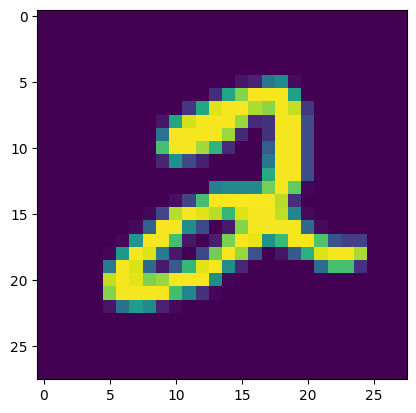

In [356]:
image,labels = train_set[5]
plt.imshow(image.squeeze())
print(labels)

In [357]:
print(f"Total images in train set are {len(train_set)}")

Total images in train set are 60000


Dataloader 

In [358]:
from torch.utils.data import DataLoader

from torchvision.utils import make_grid


In [359]:
train_loader = DataLoader(train_set,batch_size=BATCH_size,shuffle=True)

In [360]:
dataiter = iter(train_loader)
image,_=next(dataiter)
print(image.shape)

torch.Size([128, 1, 28, 28])


In [361]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.axis(False)
    plt.show()

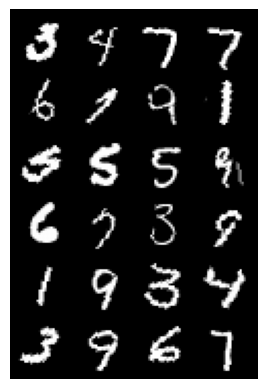

In [362]:
show_tensor_images(image,num_images=24)


Lets create Discrinator Network

its simple binary classifier. image fake or real



In [363]:
from torch import nn
from torchsummary import summary

In [364]:
'''

Network : Discriminator

input : (batch_size, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

def get_disc_block(in_channels,out_channels,kernel_size,stride):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size,stride),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )

In [365]:
class Discrimator(nn.Module):
    def __init__(self):
        super(Discrimator,self).__init__()
        self.block_1 = get_disc_block(1,16,(3,3),2)
        self.block_2 = get_disc_block(16,32,(5,5),2)
        self.block_3 = get_disc_block(32,64,(5,5),2)
        self.Flatter = nn.Flatten()
        self.linear = nn.Linear(in_features=64,out_features=1)

    def forward(self,x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.Flatter(x)
        x = self.linear(x)
        return x

In [366]:
D = Discrimator()
D.to(device)
summary(D,input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

In [367]:
'''

Network : Generator 

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1) 
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

def generator_block(in_channels,out_channels,kernel_size,stride,final_block=False):
    if final_block == True:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
            nn.Tanh()
        )
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )





In [368]:
class Generator(nn.Module):
    def __init__(self,noise_dim):
        super(Generator,self).__init__()
        self.noise_dim = noise_dim
        self.block_1=generator_block(noise_vec_dim,256,(3,3),2)
        self.block_2 = generator_block(256,128,(4,4),1)
        self.block_3 = generator_block(128,64,(3,3),2)
        self.block_4 = generator_block(64,1,(4,4),2,final_block=True)
    
    def forward(self,r_noise_dim):

        x = r_noise_dim.view(-1,self.noise_dim,1,1)
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        return x

In [369]:
G = Generator(noise_vec_dim)
G.to(device)
summary(G,input_size = (1,noise_vec_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [370]:
#replace random weights to Normal wights
def weights_init(m):  
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [371]:
D = D.apply(weights_init)
G = G.apply(weights_init)

Create loss Function and Load optimizer

In [372]:
#real loss


In [373]:
def real_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.ones_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

def fake_loss(disc_pred):
    criterion = nn.BCEWithLogitsLoss()
    ground_truth = torch.zeros_like(disc_pred)
    loss = criterion(disc_pred, ground_truth)
    return loss

In [374]:
D_optim = torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_l,beta_2))
G_optim = torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_l,beta_2))


Lets get the loop

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 1 	 D_loss: 0.6788185711608512 	 G_loss: 0.709553396142622


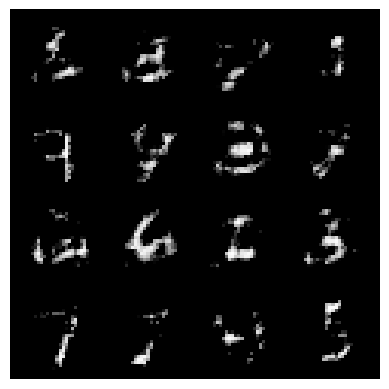

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 2 	 D_loss: 0.6400217899381478 	 G_loss: 0.7412577997138505


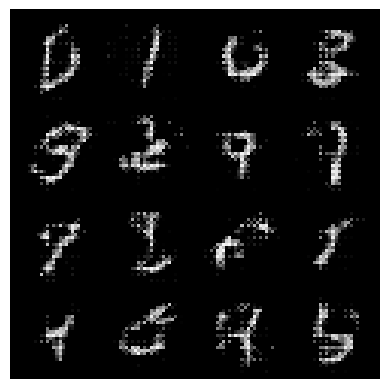

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 3 	 D_loss: 0.5801056897970659 	 G_loss: 0.8381394874820831


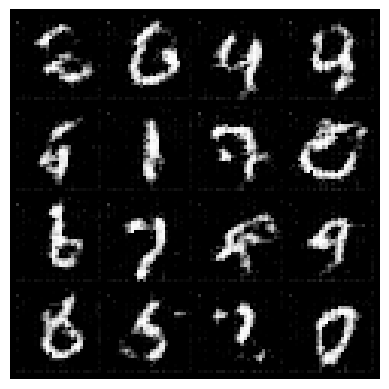

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 4 	 D_loss: 0.5516896360972797 	 G_loss: 0.9189618346787719


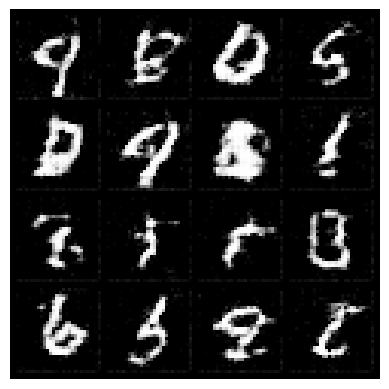

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 5 	 D_loss: 0.5616269759786154 	 G_loss: 0.9378149434447542


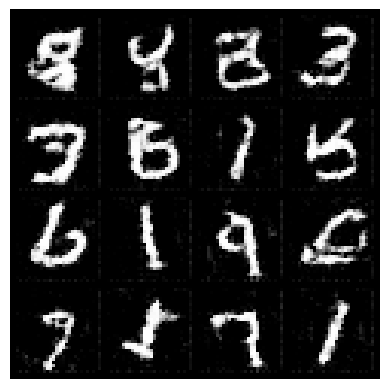

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 6 	 D_loss: 0.576349695481217 	 G_loss: 0.9375815901166594


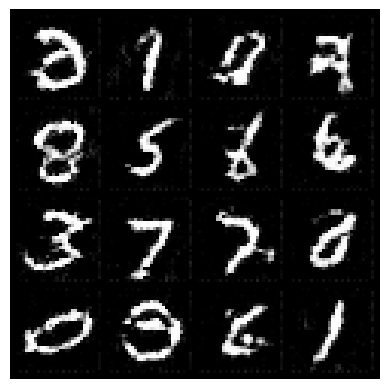

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 7 	 D_loss: 0.5966401612326535 	 G_loss: 0.9157843170389692


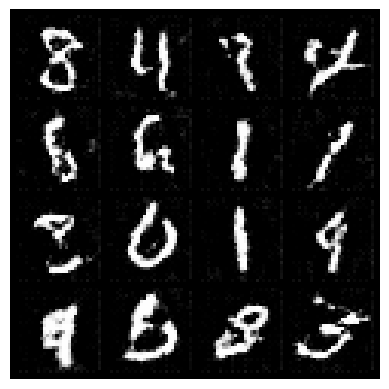

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 8 	 D_loss: 0.6127704310773024 	 G_loss: 0.8902931245151104


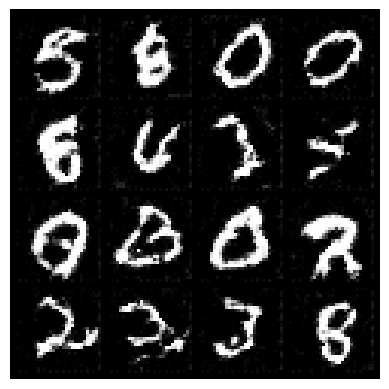

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 9 	 D_loss: 0.6208270011680213 	 G_loss: 0.874770225873634


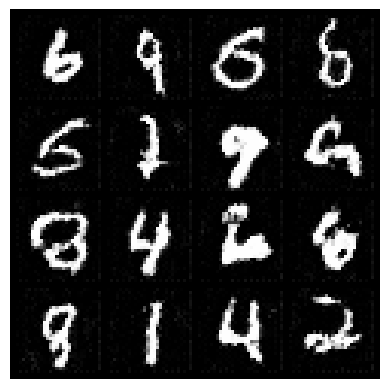

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 10 	 D_loss: 0.6248956318857319 	 G_loss: 0.8678941382273936


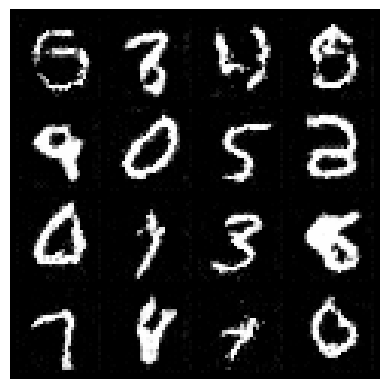

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 11 	 D_loss: 0.6256482091539705 	 G_loss: 0.8626777130657676


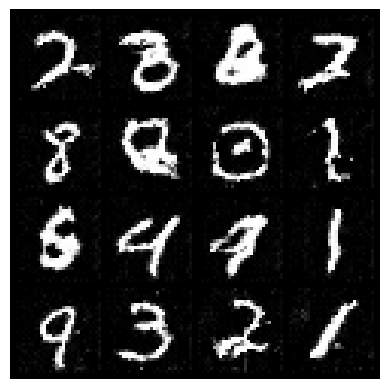

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 12 	 D_loss: 0.6265681847326283 	 G_loss: 0.8631805487787292


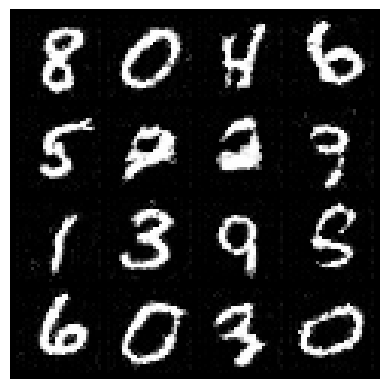

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 13 	 D_loss: 0.6284284909396792 	 G_loss: 0.8647843500190198


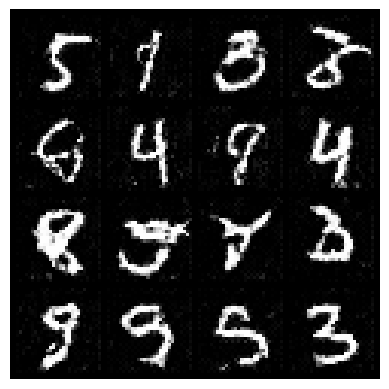

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 14 	 D_loss: 0.6303357267176418 	 G_loss: 0.8591931732987036


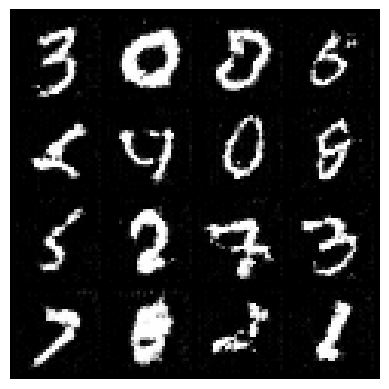

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 15 	 D_loss: 0.6308330748635315 	 G_loss: 0.8565710982534168


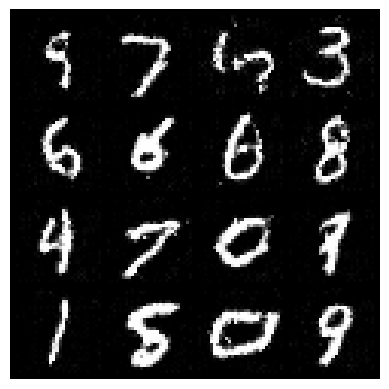

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 16 	 D_loss: 0.6300644699190217 	 G_loss: 0.8608146274267737


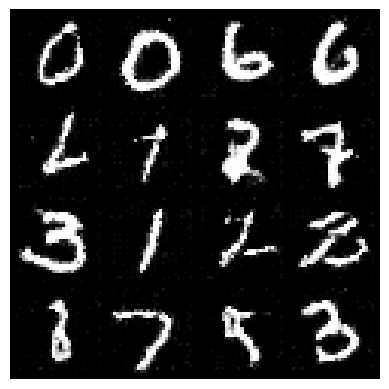

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 17 	 D_loss: 0.63095943937932 	 G_loss: 0.862794595994929


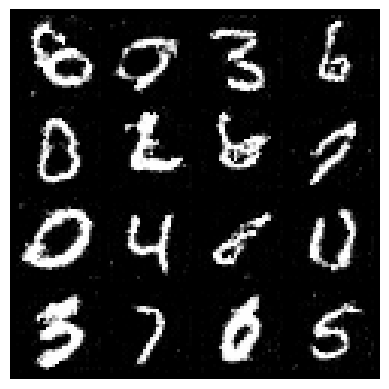

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 18 	 D_loss: 0.6293976052737693 	 G_loss: 0.8689847115768807


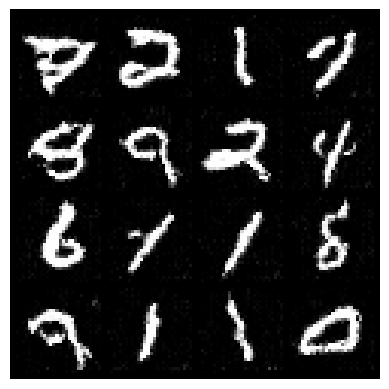

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 19 	 D_loss: 0.6286070869167222 	 G_loss: 0.871183895988505


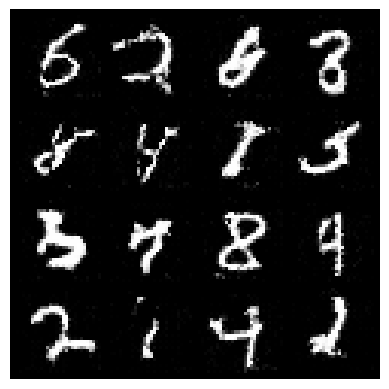

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 20 	 D_loss: 0.6266038341562885 	 G_loss: 0.8751454757474887


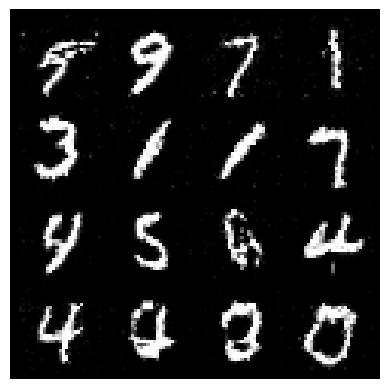

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 21 	 D_loss: 0.6244328888748755 	 G_loss: 0.8829599401589904


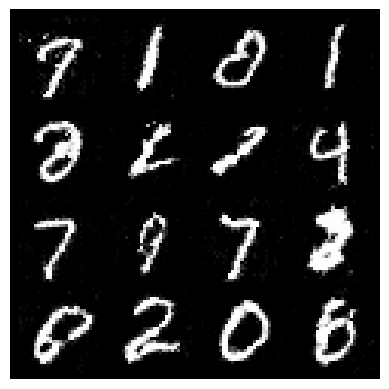

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 22 	 D_loss: 0.6216214352579259 	 G_loss: 0.8908136123533188


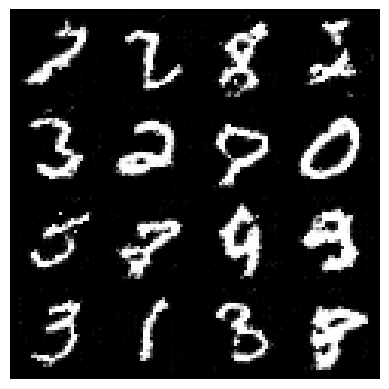

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 23 	 D_loss: 0.6190771761733586 	 G_loss: 0.8935051134654454


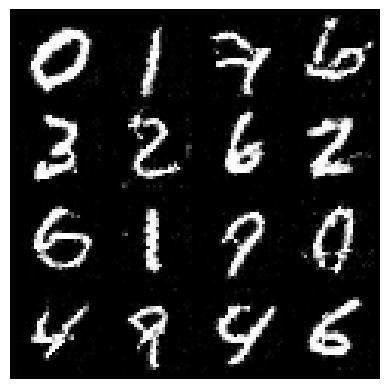

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 24 	 D_loss: 0.6173012650597578 	 G_loss: 0.9010970816175058


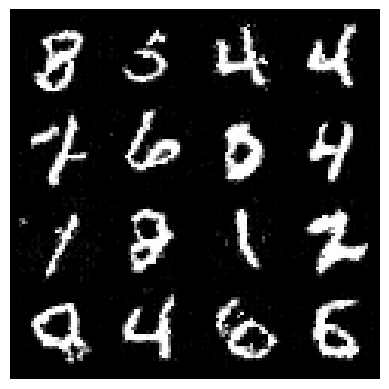

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 25 	 D_loss: 0.6154952907104736 	 G_loss: 0.9034659941313363


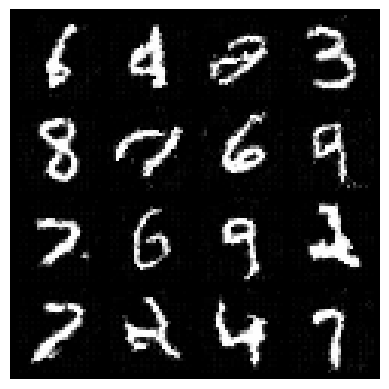

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 26 	 D_loss: 0.6112096465981083 	 G_loss: 0.9188572860984151


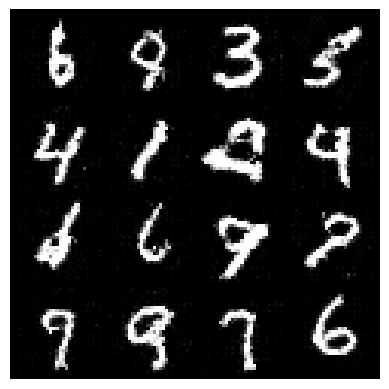

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 27 	 D_loss: 0.6123529419715978 	 G_loss: 0.9189189627989015


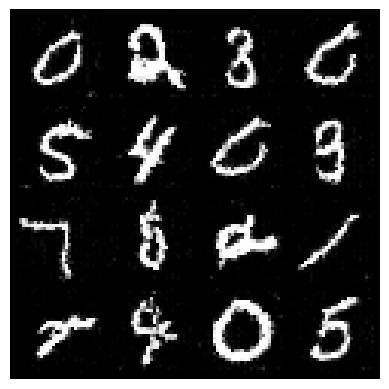

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 28 	 D_loss: 0.6129992151819567 	 G_loss: 0.9190380394077504


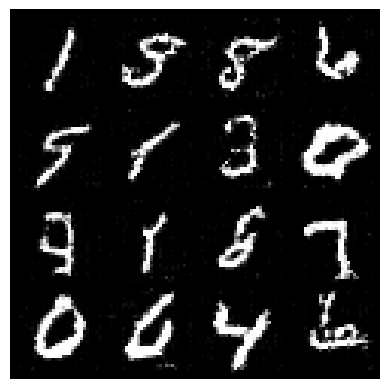

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 29 	 D_loss: 0.6100754185017746 	 G_loss: 0.9298986838316359


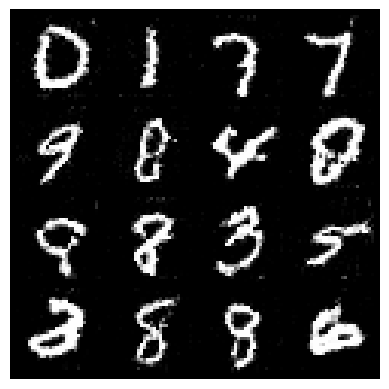

  0%|          | 0/469 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch: 30 	 D_loss: 0.610473313819625 	 G_loss: 0.9294253006926986


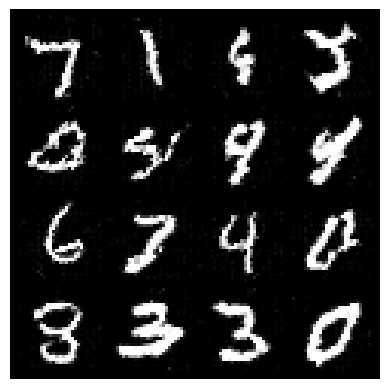

In [375]:
for epoch in range(EPOCHS):
    total_d_loss = 0.0
    total_g_loss = 0.0

    for real_img, _ in tqdm(train_loader):
        real_img = real_img.to(device)
        noise = torch.randn(BATCH_size, noise_vec_dim, device=device)

        # find loss + update weights for D
        D_optim.zero_grad()

        fake_img = G(noise)
        D_pred = D(fake_img)
        D_fake_loss = fake_loss(D_pred)

        D_pred = D(real_img)
        D_real_loss = real_loss(D_pred)

        D_loss = (D_fake_loss + D_real_loss)/2.0
        total_d_loss += D_loss.item()

        D_loss.backward()
        D_optim.step()

    # find loss + update weights for G
        G_optim.zero_grad()

        noise = torch.randn(BATCH_size, noise_vec_dim, device=device)
        
        fake_img = G(noise)
        D_pred = D(fake_img)
        G_loss = real_loss(D_pred)  # want to generate as real as possible
        total_g_loss += G_loss.item()
        
        G_loss.backward()
        G_optim.step()
  
    avg_d_loss = total_d_loss/len(train_loader)
    avg_g_loss = total_g_loss/len(train_loader)

    print('Epoch: {} \t D_loss: {} \t G_loss: {}'.format(epoch+1, avg_d_loss, avg_g_loss))

    show_tensor_images(fake_img)